In [1]:
import tensorflow as tf
import pathlib
# Putanja do osnovnog direktorija dataset-a
base_dir = pathlib.Path('test')

# Učitavanje podataka
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# nesto ddoao
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

# Spremanje imena klasa
class_names = train_ds.class_names
print(class_names)
# Sada možete normalizovati dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Kada definirate model, koristite spremljene class_names za definiranje posljednjeg Dense sloja
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names))  # Koristi spremljenu varijablu class_names
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)




Found 1983 files belonging to 21 classes.
Using 1389 files for training.
Found 1983 files belonging to 21 classes.
Using 594 files for validation.
['Earth', 'Jupiter', 'MakeMake', 'Mars', 'Mercury', 'Moon', 'Neptune', 'Pluto', 'Saturn', 'Uranus', 'Venus', 'callisto', 'deimos', 'enceladus', 'europa', 'ganymede', 'io', 'mimas', 'phobos', 'rhea', 'titan']



Epoch 1/10


44/44 [==============================] - 8s 136ms/step - loss: 1.5977 - accuracy: 0.5400 - val_loss: 63.9838 - val_accuracy: 0.8286
Epoch 2/10
44/44 [==============================] - 6s 127ms/step - loss: 0.5911 - accuracy: 0.8308 - val_loss: 103.8988 - val_accuracy: 0.8048
Epoch 3/10
44/44 [==============================] - 6s 128ms/step - loss: 0.3368 - accuracy: 0.8978 - val_loss: 98.2418 - val_accuracy: 0.7905
Epoch 4/10
44/44 [==============================] - 6s 128ms/step - loss: 0.2483 - accuracy: 0.9208 - val_loss: 91.3066 - val_accuracy: 0.8333
Epoch 5/10
44/44 [==============================] - 6s 128ms/step 

12/12 [==============================] - 1s 58ms/step


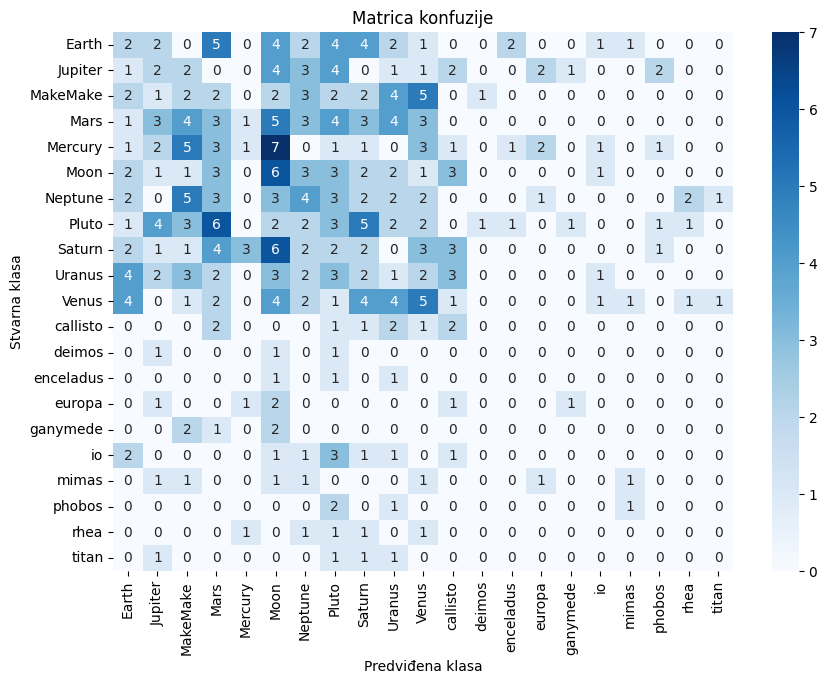

12/12 [==============================] - 1s 59ms/step - loss: 117.8253 - accuracy: 0.8594
Test accuracy: 0.859375
Test loss: 117.82532501220703


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np

# Predviđanja modela za test skup
predictions = np.argmax(model.predict(test_ds), axis=-1)

# Stvarne vrednosti za test skup
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Izračunavanje matrice konfuzije
conf_matrix = confusion_matrix(true_labels, predictions)


# Kreiranje DataFrame-a za matricu konfuzije
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()


# Evaluacija modela na test skupu
loss, accuracy = model.evaluate(test_ds)
print("Test accuracy:", accuracy)
print("Test loss:", loss)

1/1 [==============================] - 0s 37ms/step


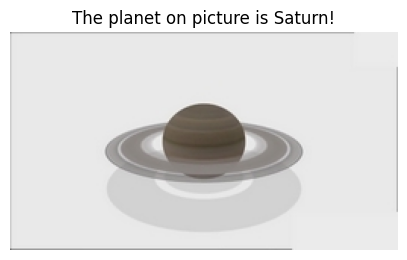

1/1 [==============================] - 0s 31ms/step


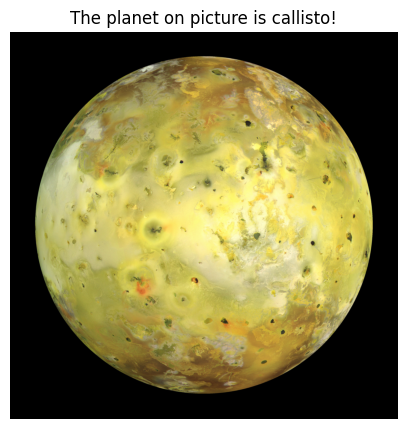

1/1 [==============================] - 0s 31ms/step


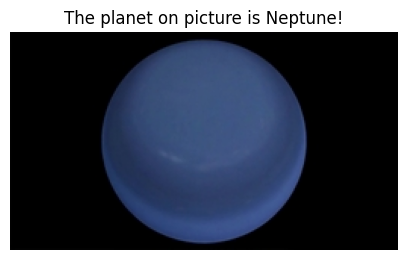

1/1 [==============================] - 0s 29ms/step


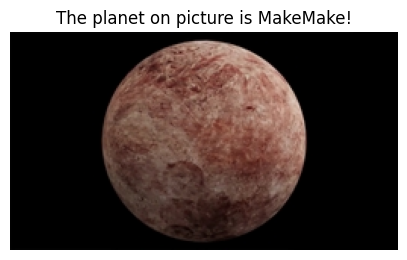

1/1 [==============================] - 0s 31ms/step


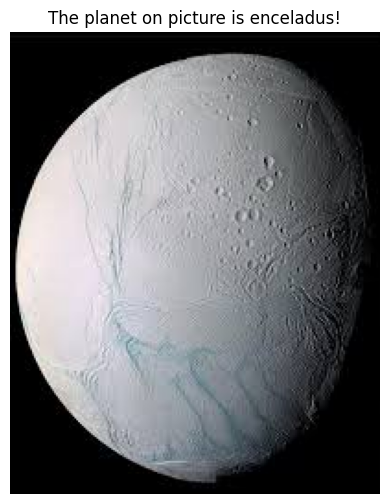

1/1 [==============================] - 0s 30ms/step


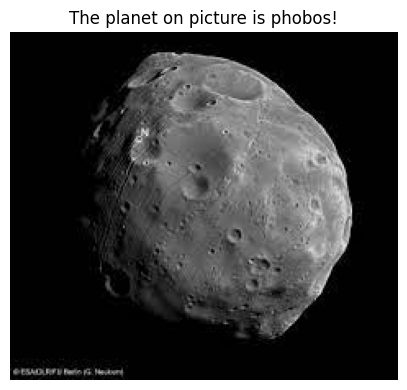

1/1 [==============================] - 0s 29ms/step


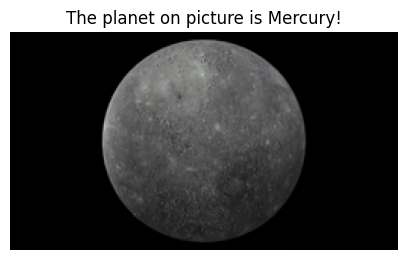

1/1 [==============================] - 0s 31ms/step


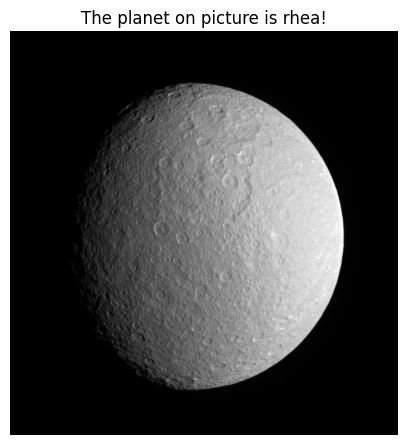

1/1 [==============================] - 0s 34ms/step


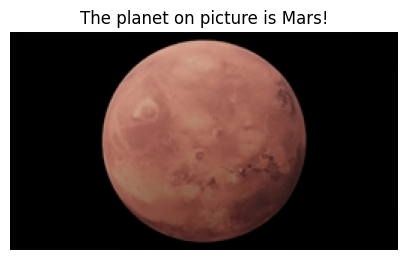

1/1 [==============================] - 0s 29ms/step


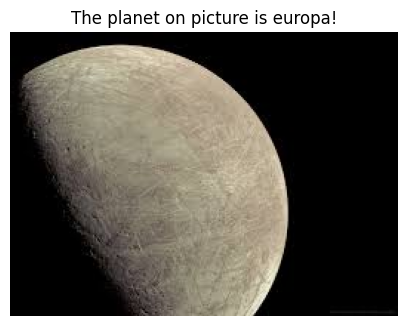

1/1 [==============================] - 0s 32ms/step


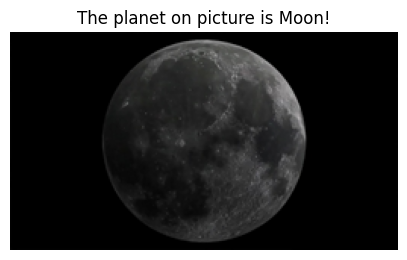

1/1 [==============================] - 0s 31ms/step


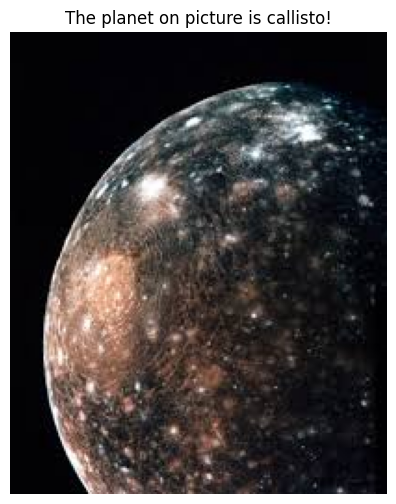

1/1 [==============================] - 0s 31ms/step


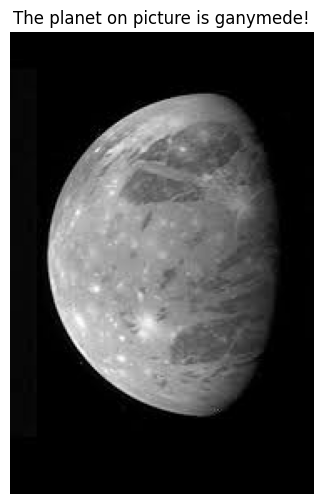

1/1 [==============================] - 0s 30ms/step


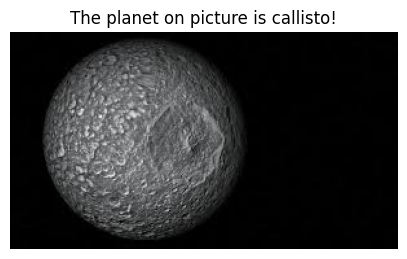

1/1 [==============================] - 0s 32ms/step


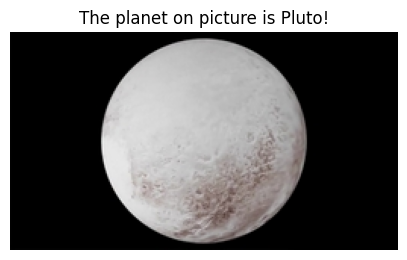

In [6]:
from tensorflow.keras.preprocessing import image
import random
import os

# Get a random sample of 5 images from the original dataset

random_planets = random.sample(os.listdir(base_dir), 15)

for planet in random_planets:

    random_image = random.sample(os.listdir( os.path.join(base_dir, planet) ), 1)
    
    # Load the image
    img_path = os.path.join(base_dir, planet, random_image[0])
    img = image.load_img(img_path, target_size=(180,180))
    img_array = image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values to [0, 1]

    # Preprocess the image (resize and normalize) and make a prediction
    img_input = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_input)
    predicted_class = class_names[np.argmax(prediction)]

    # Display the image and the predicted class
    plt.figure(figsize=(5, 6))
    real_img = image.load_img(img_path)
    plt.imshow(real_img)
    plt.axis('off')
    plt.title(f"The planet on picture is {predicted_class}!")
    plt.show()